### A Notebook to showcase release 0.12.0: use of `segment`, `apply_ragged`, `chunk`, and `velocity_from_position` functions

1. Example of segment to calculate velocity
2. Example of chunks to calculate the Latitude-Frequency spectra (Elipot spectra)

In [9]:
import clouddrift as cd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
#from fast_histogram import histogram1d  

In [10]:
from clouddrift.analysis import segment,chunk, velocity_from_position

In [11]:
#url_path = 'https://noaa-oar-hourly-gdp-pds.s3.amazonaws.com/latest/'
#url_path = 'https://noaa-oar-hourly-gdp-pds.s3.us-east-1.amazonaws.com/latest/'
#file = 'gdp_v2.00.nc'
#ds = xr.open_dataset(url_path+file+'#mode=bytes')
file = '/Users/selipot/Data/awss3/latest/gdp_v2.00.nc'
ds = xr.open_dataset(file)

In [12]:
ds

<xarray.Dataset>
Dimensions:                (traj: 17324, obs: 165754333)
Coordinates:
    ids                    (obs) int64 ...
    time                   (obs) datetime64[ns] ...
    lon                    (obs) float32 ...
    lat                    (obs) float32 ...
Dimensions without coordinates: traj, obs
Data variables: (12/55)
    ID                     (traj) int64 ...
    rowsize                (traj) int32 ...
    WMO                    (traj) int32 ...
    expno                  (traj) int32 ...
    deploy_date            (traj) datetime64[ns] ...
    deploy_lat             (traj) float64 ...
    ...                     ...
    err_sst1               (obs) float64 ...
    err_sst2               (obs) float64 ...
    flg_sst                (obs) int8 ...
    flg_sst1               (obs) int8 ...
    flg_sst2               (obs) int8 ...
    drogue_status          (obs) bool ...
Attributes: (12/16)
    title:             Global Drifter Program hourly drifting buoy collection
    history:           Version 2.00.  Metadata from dirall.dat and deplog.dat
    Conventions:       CF-1.6
    date_created:      2022-12-09T06:02:29.684949
    publisher_name:    GDP Drifter DAC
    publisher_email:   aoml.dftr@noaa.gov
    ...                ...
    contributor_name:  NOAA Global Drifter Program
    contributor_role:  Data Acquisition Center
    institution:       NOAA Atlantic Oceanographic and Meteorological Laboratory
    acknowledgement:   Elipot, Shane; Sykulski, Adam; Lumpkin, Rick; Centurio...
    summary:           Global Drifter Program hourly data
    doi:               10.25921/x46c-3620

In [13]:
hist,edges = np.histogram(ds.ve, 200, (-1,1))

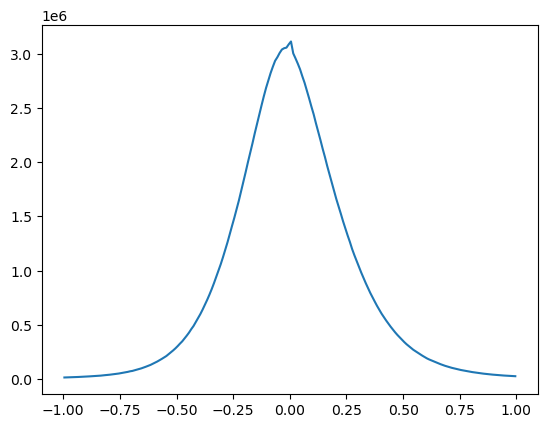

In [14]:
plt.plot(0.5*(edges[:-1]+edges[1:]),(hist),'-')

Some explanation about the ragged array representation of the data and how the GDP data are organized. In order to access the data for one given trajectory, one needs to build a trajectory index. This is conveniently done from the `rowsize` variable that indicates the number of rows in the ragged array for each trajectory. 

In [15]:
# create a trajectory index
traj_idx = np.insert(np.cumsum(ds.rowsize.values), 0, 0)

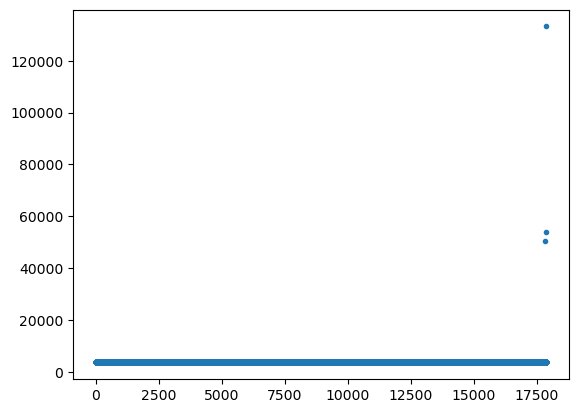

In [16]:
j = 100
sli = slice(traj_idx[j], traj_idx[j+1])
plt.plot(np.diff(ds.time[sli])/1e9,'.')

In [17]:
time = ds.time[sli]
time

<xarray.DataArray 'time' (obs: 17874)>
[17874 values with dtype=datetime64[ns]]
Coordinates:
    ids      (obs) int64 ...
    time     (obs) datetime64[ns] ...
    lon      (obs) float32 ...
    lat      (obs) float32 ...
Dimensions without coordinates: obs
Attributes:
    long_name:  Time

In [18]:
q = np.where(np.diff(time)>np.timedelta64(3600, 's'))
q

(array([17832, 17862, 17867]),)

In [19]:
segment?

Signature:
segment(
    x: numpy.ndarray,
    tolerance: Union[float, numpy.timedelta64, datetime.timedelta, pandas._libs.tslibs.timedeltas.Timedelta],
    rowsize: numpy.ndarray[int] = None,
) -> numpy.ndarray[int]
Docstring:
Segment an array into contiguous segments.

Parameters
----------
x : list, np.ndarray, or xr.DataArray
    An array to segment.
tolerance : float, np.timedelta64, timedelta, pd.Timedelta
    The maximum signed difference between consecutive points in a segment.
rowsize : np.ndarray[int], optional
    The size of rows if x is a ragged array. If present, x will be
    segmented both by gaps that exceed the tolerance, and by rows
    of the ragged array.

Returns
-------
segment_sizes : np.ndarray[int]
    An array of row-sizes that segment the input array into contiguous segments.

Examples
--------

The simplest use of ``segment`` is to provide a tolerance value that is
used to segment an array into contiguous segments.

>>> x = [0, 1, 1, 1, 2, 2, 3, 3, 3, 3, 4]


In [20]:
x = [0, 1, 1, 1, 2, 2, 3, 3, 3, 3, 4]
print(np.diff(x)>1)
segment(x,0.5)

[False False False False False False False False False False]


array([1, 3, 2, 4, 1])

In [21]:
from datetime import timedelta

In [22]:
dt = np.timedelta64(3600, 's') # timedelta(seconds=1800)
#dt = 1800
dt

numpy.timedelta64(3600,'s')

In [23]:
row1 = segment(time,tolerance=dt,rowsize=np.array([17874]))
row1

array([17833,    30,     5,     6])

In [24]:
display(np.sum(row1))
display(len(time))

17874

17874

In [25]:
newrowsize1 = segment(ds.time,dt,rowsize=ds.rowsize)

KeyboardInterrupt: 

In [ ]:
np.shape(newrowsize1) # should be 88933?

(88933,)

In [ ]:
#newrowsize = segment(ds.time,tolerance=dt)
#newrowsize = segment(ds.time, dt, rowsize=segment(ds.time, -dt,rowsize=ds.rowsize))

The results should be 88933 segments

In [ ]:
np.shape(newrowsize1) # should be 88933? got it

(88933,)

However, some segments are only of length one.

In [ ]:
np.sum(newrowsize1==1)

1130

Next, we want to illustrate the use of operations per segments, such as calculating velocity from successive positions. This requires a segment to be at least of length 2. As a result we first need to remove or mask the length one segments.

In [ ]:
a = np.array([1,2,3,4,5,6,7,8,9,10])
np.delete(a,np.where(np.mod(a,2)==1))

array([ 2,  4,  6,  8, 10])

In [ ]:
mask = np.where(np.mod(a,2)!=1)
a[mask]

array([ 2,  4,  6,  8, 10])

In [ ]:
# create new segment index
seg_idx = np.insert(np.cumsum(newrowsize1), 0, 0)
np.shape(seg_idx)

(88934,)

In [ ]:
time = ds.time
lat = ds.lat
lon = ds.lon
ve = ds.ve
vn = ds.vn

In [ ]:
# create a mask for the segments of row length 1
q1 = np.where(newrowsize1==1)
slices = []
for j in q1[0]:
    slices.append(slice(seg_idx[j], seg_idx[j+1]))
keep_mask = np.ones_like(time,dtype=bool)
for slice in slices: keep_mask[slice] = False
    

In [ ]:
# remove rows of length 1
time = time[keep_mask]
np.shape(time)


(165753203,)

In [ ]:
np.shape(ds.time)[0]-np.shape(time)[0] == len(q1[0])

True

In [ ]:
lat = lat[keep_mask]
lon = lon[keep_mask]
ve = ve[keep_mask]
vn = vn[keep_mask]


In [ ]:
# define the new rowsize variable
newrowsize2 = np.delete(newrowsize1,q1)
len(newrowsize2)

87803

In [ ]:
# create new segment index
seg_idx2 = np.insert(np.cumsum(newrowsize2), 0, 0)
np.shape(seg_idx2)

(87804,)

In [ ]:
88933-1130

87803

In [ ]:
from clouddrift.analysis import apply_ragged

In [ ]:
u,v = apply_ragged(velocity_from_position,[lon,lat,time],newrowsize2,coord_system='spherical')

In [ ]:
del slice

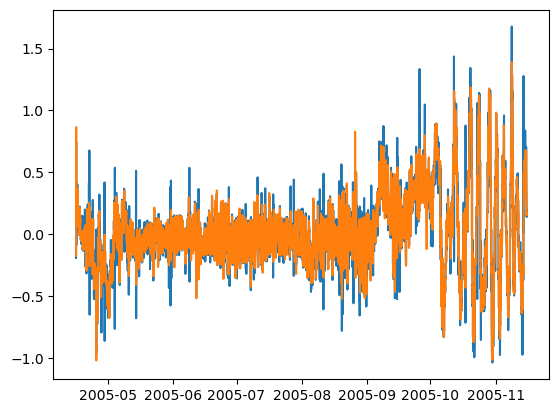

In [ ]:
j = 0
sli = slice(seg_idx2[j],seg_idx2[j+1])
plt.plot(time[sli],u[sli]*1e9)
plt.plot(time[sli],ve[sli])

In [ ]:
len(u)

165753203

In [ ]:
hist1, bin_edges1 = np.histogram(u*1e9-ve,200,(-1,1))
#hist2 = histogram1d(u*1e9-ve,200,(-1,1))

/var/folders/zf/wc1ydrbd1vd312tpk07xh2840000gn/T/ipykernel_39090/3481782820.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(0.5*(bin_edges1[:-1]+bin_edges1[1:]),np.log10(hist1),'-')


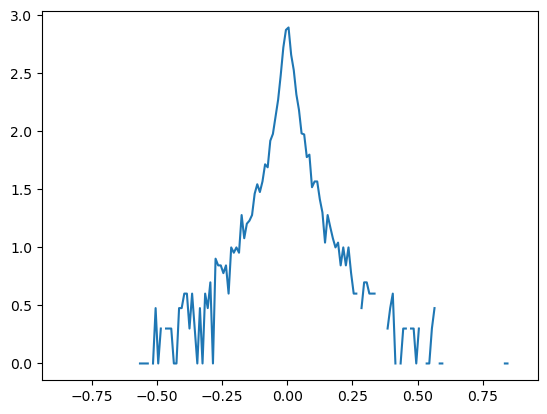

In [ ]:
#plt.plot(bin_edges1[0:-1],hist1,'.-')
plt.plot(0.5*(bin_edges1[:-1]+bin_edges1[1:]),np.log10(hist1),'-')

In [ ]:
hist_ve = histogram1d(ve,200,(-1,1))

In [ ]:
a = np.random.rand(1_000_000_000)

In [ ]:
np.histogram(a)

(array([100007063,  99971851, 100004015, 100002975, 100004209, 100002213,
        100014575, 100003567,  99999132,  99990400]),
 array([1.70220360e-09, 1.00000001e-01, 2.00000001e-01, 3.00000001e-01,
        4.00000001e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 8.99999999e-01, 9.99999999e-01]))